## Scattered data interpolation via nonnegative least squares deconvolution

This notebook describes and compares several methods of scattered data interpolation.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.optimize as optimize
import pygsvd
from sampling import Sampling
from roll_zeropad import roll_zeropad
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = [9., 7.]
dpi = 100

## Modelling the image with nonnegative constraints

The linear problem can be solved with non-negative constraints. This choice regularizes much of the bad behavior. With no noise, the result is completely unchanged from the linear fit. Note that in this case, this result cannot be interpreted exactly as the "PSF" because the method is not linear.

In [2]:
sampling = Sampling(nsamples=1000)
sampling.set_flux(total_flux=1000., noise=1.e-3)

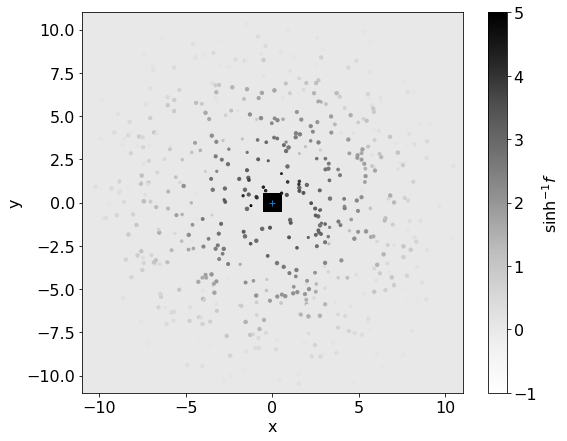

In [3]:
x = optimize.nnls(sampling.A, sampling.flux_nonoise)
S_FF = x[0].reshape(sampling.nx, sampling.ny)
sampling.imshow(S_FF)
plt.savefig('../tex/figures/tmp/scattered-nnls-noiseless.png', dpi=dpi)

But with noise, it doesn't fail immediating the way the linear case does. 

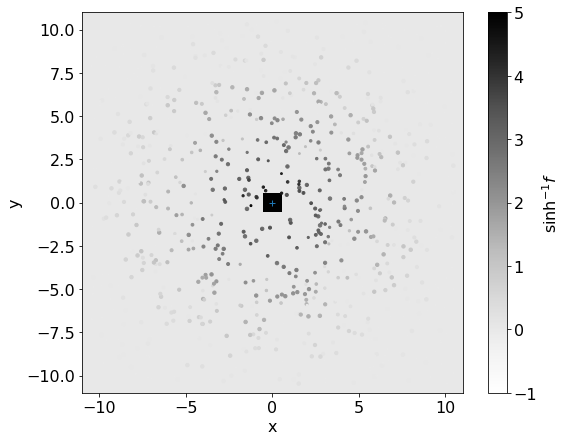

In [4]:
x = optimize.nnls(sampling.A, sampling.flux)
S_FF = x[0].reshape(sampling.nx, sampling.ny)
sampling.imshow(S_FF)

There is more of an effect with more noise of course.

In [5]:
sampling.set_flux(total_flux=1000., noise=1.)

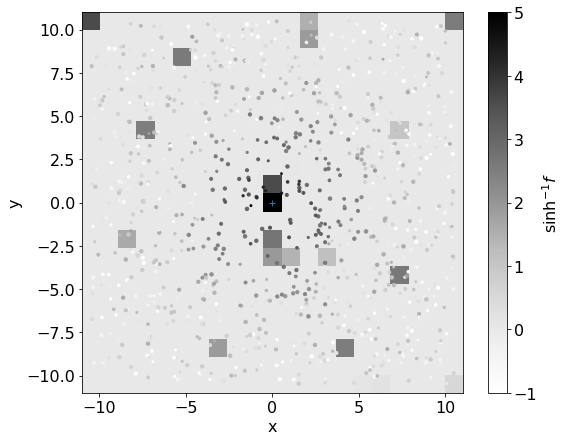

In [6]:
x = optimize.nnls(sampling.A, sampling.flux)
S_FF = x[0].reshape(sampling.nx, sampling.ny)
sampling.imshow(S_FF)
plt.savefig('../tex/figures/tmp/scattered-nnls-noisy.png', dpi=dpi)

In particular, you start seeing areas where pixels fluctuate very high to explain little noise spikes.

In [7]:
sampling.set_flux(total_flux=1000., noise=10.)

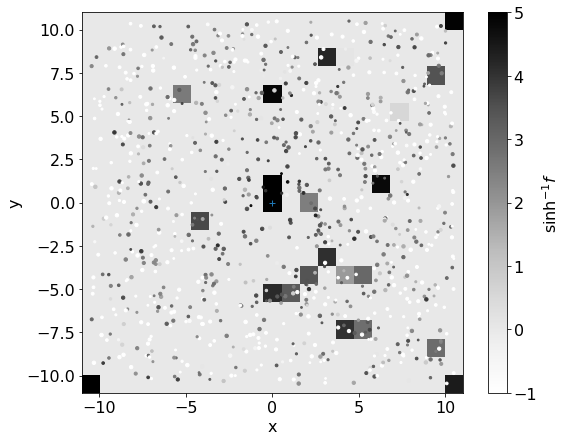

In [8]:
x = optimize.nnls(sampling.A, sampling.flux)
S_FF = x[0].reshape(sampling.nx, sampling.ny)
sampling.imshow(S_FF)

## PSF dependence on noise

In the absence of noise, the NNLS result is the same as the linear result. Therefore, in that limited case it really does have a PSF. However, when noise is present, the response to a point source is changed. 

To study this we must consider the expectation value of the result over many realizations in the presence of noise. There are at least two things we learn from this: first, the profile of the response is affected by the noise level, and second, that the nonnegative constraints lead to a bias in the background level (since fluctuations above zero lead to a positive response but fluctuations below zero lead to a zero response).

In [9]:
def Sexpected(sampling, total_flux=1000., noise=10., nsample=50000,
              xcen=0., ycen=0.):
    Sarr = np.zeros((nsample, sampling.nx, sampling.ny))
    for i in np.arange(nsample):
        sampling.set_flux(total_flux=total_flux, noise=noise, xcen=xcen, ycen=ycen)
        x = optimize.nnls(sampling.A, sampling.flux)
        Sarr[i, :, :] = x[0].reshape(sampling.nx, sampling.ny)
    Sexp = Sarr.mean(axis=0)
    return(Sarr, Sexp)

In [10]:
Sarr_100, Sexp_100 = Sexpected(sampling, noise=100.)
fitsio.write('nnls_sexp_100.fits', Sexp_100, clobber=True)
fitsio.write('nnls_sexp_100.fits', Sarr_100, clobber=False)
Sexp_100 = fitsio.read('nnls_sexp_100.fits', ext=0)
Sarr_100 = fitsio.read('nnls_sexp_100.fits', ext=1)
sampling.imshow(Sexp_100, vmax=6.5, nopoints=True)
plt.savefig('../tex/figures/tmp/scattered-nnls-mean-100.png', dpi=dpi)

NameError: name 'fitsio' is not defined

In [ ]:
from gplusb import gplusb
(sigma, flux, background, model) = gplusb(sampling, Sexp_100)
print("sigma = {sigma}".format(sigma=sigma))
print("flux = {flux}".format(flux=flux))
print("background = {background}".format(background=background))
sampling.imshow(Sexp_100 - model, vmax=6.5, nopoints=True)

In [ ]:
Sarr_30, Sexp_30 = Sexpected(sampling, noise=30.)
fitsio.write('nnls_sexp_30.fits', Sexp_30, clobber=True)
fitsio.write('nnls_sexp_30.fits', Sarr_30, clobber=False)
Sexp_30 = fitsio.read('nnls_sexp_30.fits', ext=0)
Sarr_30 = fitsio.read('nnls_sexp_30.fits', ext=1)
sampling.imshow(Sexp_30, vmax=6.5, nopoints=True)
plt.savefig('../tex/figures/tmp/scattered-nnls-mean-30.png', dpi=dpi)

In [ ]:
from gplusb import gplusb
(sigma, flux, background, model) = gplusb(sampling, Sexp_1)
print("sigma = {sigma}".format(sigma=sigma))
print("flux = {flux}".format(flux=flux))
print("background = {background}".format(background=background))
sampling.imshow(Sexp_1 - model, vmax=6.5, nopoints=True)

In [ ]:
Sarr_1, Sexp_1 = Sexpected(sampling, noise=1.)
fitsio.write('nnls_sexp_1.fits', Sexp_1, clobber=True)
fitsio.write('nnls_sexp_1.fits', Sarr_1, clobber=False)
Sexp_1 = fitsio.read('nnls_sexp_1.fits', ext=0)
Sarr_1 = fitsio.read('nnls_sexp_1.fits', ext=1)
sampling.imshow(Sexp_1, vmax=6.5, nopoints=True)
plt.savefig('../tex/figures/tmp/scattered-nnls-mean-1.png', dpi=dpi)

In [ ]:
from gplusb import gplusb
(sigma, flux, background, model) = gplusb(sampling, Sexp_1)
print("sigma = {sigma}".format(sigma=sigma))
print("flux = {flux}".format(flux=flux))
print("background = {background}".format(background=background))
sampling.imshow(Sexp_1 - model, vmax=6.5, nopoints=True)

In [ ]:
xg = sampling.xgrid.reshape(sampling.nx, sampling.ny)
plt.plot(xg[10, :], np.log10(Sexp_100[10, :]), color='black', label='noise = 100')
plt.plot(xg[10, :], np.log10(Sexp_30[10, :]), color='red', label='noise = 30')
plt.plot(xg[10, :], np.log10(Sexp_1[10, :]), color='blue', label='noise = 1')
plt.legend(fontsize=14, loc=1)
plt.xlabel('X')
plt.ylabel('$\log_{10}$ mean response')
plt.savefig('../tex/figures/scattered-nnls-mean-slice.png', dpi=dpi)

## Nonlinearity (two point sources)

Because this method is not linear, you can't really think of the noiseless response as a PSF. For example, if you put in two point sources, the sum of their deconvolution is not the deconvolution of their sum. 

Because of the nature of NNLS, however, this only becomes apparent in the presence of noise. Without noise, the nonnegative constraints do not affect the fit, so things remain linear.

In [16]:
sampling.set_flux(total_flux=1000., noise=0., xcen=0.0, ycen=0.0)
f1 = sampling.flux
f1_nonoise = sampling.flux_nonoise
sampling.set_flux(total_flux=1000., noise=1., xcen=1.0, ycen=1.0)
f2 = sampling.flux
f2_nonoise = sampling.flux_nonoise
f12 = f1 + f2
f12_nonoise = f1_nonoise + f2_nonoise

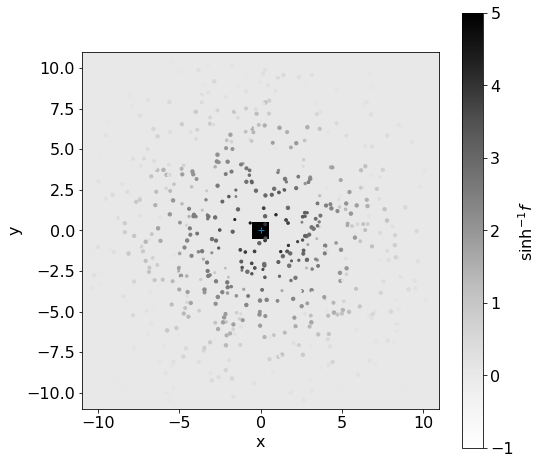

In [17]:
sampling.flux = f1
sampling.flux_nonoise = f1_nonoise
x = optimize.nnls(sampling.A, sampling.flux_nonoise)
S_N_1 = x[0].reshape(sampling.nx, sampling.ny)
sampling.imshow(S_N_1)

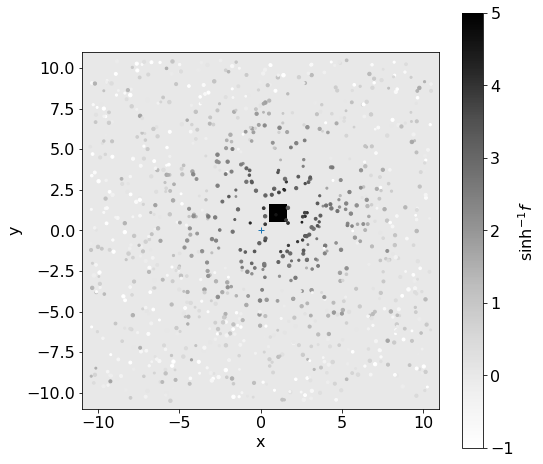

In [18]:
sampling.flux = f2
sampling.flux_nonoise = f2_nonoise
x = optimize.nnls(sampling.A, sampling.flux_nonoise)
S_N_2 = x[0].reshape(sampling.nx, sampling.ny)
sampling.imshow(S_N_2)

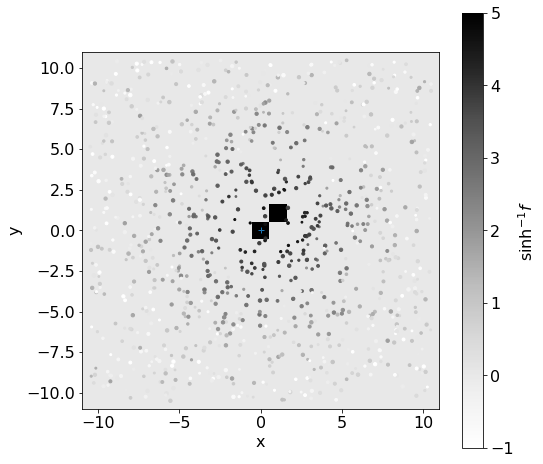

In [19]:
sampling.flux = f12
sampling.flux_nonoise = f12_nonoise
x = optimize.nnls(sampling.A, sampling.flux_nonoise)
S_N_12 = x[0].reshape(sampling.nx, sampling.ny)
sampling.imshow(S_N_12)

As for the dependence of the point source response on signal-to-noise ratio, we again need to look at the expectation value of the response using a Monte Carlo approach. 

In [20]:
def Sexpected2(sampling, total_flux=1000., noise=1., nsample=3000,
               xcen1=0., ycen1=0., xcen2=1., ycen2=1.):
    Sarr1 = np.zeros((nsample, sampling.nx, sampling.ny))
    Sarr2 = np.zeros((nsample, sampling.nx, sampling.ny))
    Sarr12 = np.zeros((nsample, sampling.nx, sampling.ny))
    for i in np.arange(nsample):
        sampling.set_flux(total_flux=total_flux, noise=noise, xcen=xcen1, ycen=ycen1)
        f1 = sampling.flux
        x = optimize.nnls(sampling.A, sampling.flux)
        Sarr1[i, :, :] = x[0].reshape(sampling.nx, sampling.ny)
        sampling.set_flux(total_flux=total_flux, noise=noise, xcen=xcen2, ycen=ycen2)
        f2 = sampling.flux
        x = optimize.nnls(sampling.A, sampling.flux)
        Sarr2[i, :, :] = x[0].reshape(sampling.nx, sampling.ny)
        sampling.flux = f1 + f2
        x = optimize.nnls(sampling.A, sampling.flux)
        Sarr12[i, :, :] = x[0].reshape(sampling.nx, sampling.ny)
    Sexp1 = Sarr1.mean(axis=0)
    Sexp2 = Sarr2.mean(axis=0)
    Sexp12 = Sarr12.mean(axis=0)
    return(Sarr1, Sexp1, Sarr2, Sexp2, Sarr12, Sexp12)

In [21]:
(Sarr1, Sexp1, Sarr2, Sexp2, Sarr12, Sexp12) = Sexpected2(sampling, noise=30.)

-0.27499659901140344


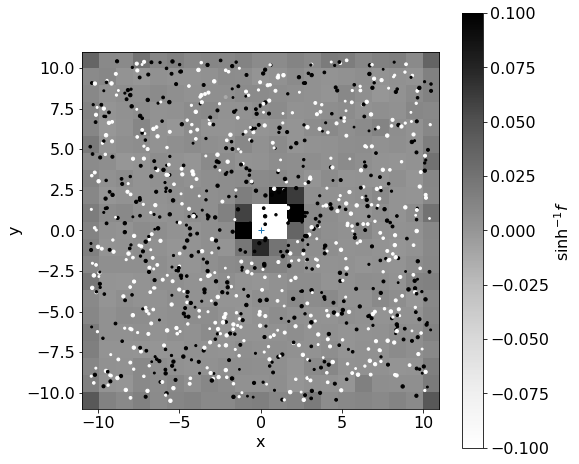

In [22]:
sampling.imshow(np.sinh(((Sexp1 + Sexp2) - (Sexp12)) / Sexp12.max()) , vmin=-0.1, vmax=0.1)
print((((Sexp1 + Sexp2) - (Sexp12)) / Sexp12.max()).min())

## Diffuse sources

The nonlinearity found above implies that this method may behave differently for point sources versus extended sources. A simple test to consider is simply a flat uniform background. How does the algorithm behave in that case?

In [23]:
sampling = Sampling(nsamples=1000, sigmarange=[1., 4.])
flat = np.ones(sampling.A.shape[1]) * 1000.
sampling.set_flux(total_flux=0., noise=10.)
sampling.flux = sampling.flux + sampling.A.dot(flat)
sampling.flux_nonoise = sampling.flux_nonoise + sampling.A.dot(flat)

In the case of no noise, obviously it works great.

In [24]:
print(sampling.flux_nonoise.mean())

818.0238139840469


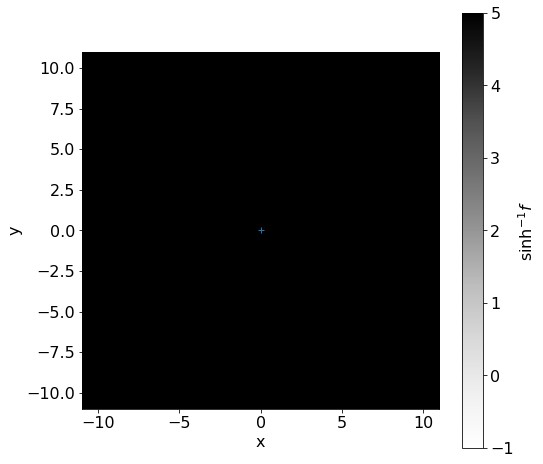

In [25]:
x = optimize.nnls(sampling.A, sampling.flux_nonoise)
S_N = x[0].reshape(sampling.nx, sampling.ny)
sampling.imshow(S_N)

But in the presence of noise, the degeneracies arise. Basically, just like in the linear case, neighboring pixels can trade off their flux in many cases.

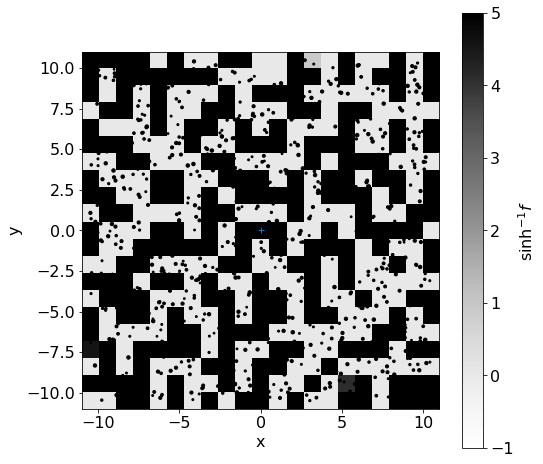

In [26]:
x = optimize.nnls(sampling.A, sampling.flux)
S_N = x[0].reshape(sampling.nx, sampling.ny)
sampling.imshow(S_N)
plt.savefig('../tex/figures/scattered-nnls-flat.png', dpi=dpi)

In [27]:
def SexpectedFlat(sampling, total_flux=0., noise=10., nsample=1000,
              xcen=0., ycen=0., flat_flux=1000.):
    flat = np.ones(sampling.A.shape[1]) * flat_flux
    Sarr = np.zeros((nsample, sampling.nx, sampling.ny))
    for i in np.arange(nsample):
        sampling.set_flux(total_flux=total_flux, noise=noise, xcen=xcen, ycen=ycen)
        sampling.flux = sampling.flux + sampling.A.dot(flat)
        sampling.flux_nonoise = sampling.flux_nonoise + sampling.A.dot(flat)
        x = optimize.nnls(sampling.A, sampling.flux)
        Sarr[i, :, :] = x[0].reshape(sampling.nx, sampling.ny)
    Sexp = Sarr.mean(axis=0)
    return(Sarr, Sexp)

In [28]:
SarrFlat, SexpFlat = SexpectedFlat(sampling)

In [31]:
nsample = sampling.nsamples
SarrFlatFlat = SarrFlat.reshape(SarrFlat.shape[0], sampling.nx * sampling.ny)
C_FF = np.zeros((sampling.nx * sampling.ny, sampling.nx * sampling.ny))
for i in np.arange(sampling.nx * sampling.ny):
    for j in np.arange(sampling.nx * sampling.ny):
        C_FF[i, j] = (((SarrFlatFlat[:, i] - SarrFlatFlat[:, i].mean()) *
                       (SarrFlatFlat[:, j] - SarrFlatFlat[:, j].mean())).sum() /
                       np.float32(nsample))

In [32]:
CC_FF = 0. * C_FF
for i in np.arange(sampling.nx * sampling.ny):
    for j in np.arange(sampling.nx * sampling.ny):
        CC_FF[i, j] = C_FF[i, j] / np.sqrt(C_FF[i, i] * C_FF[j, j])

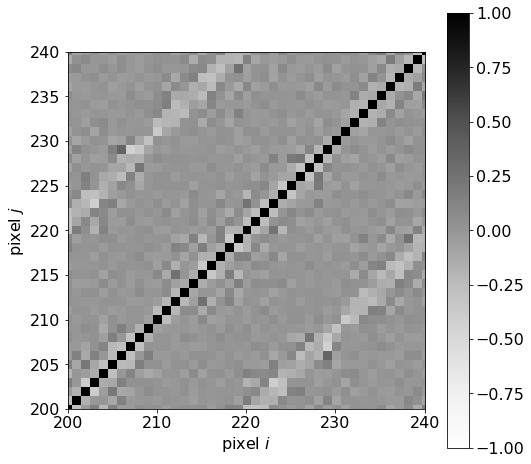

In [33]:
myargs = {'interpolation': 'nearest', 'origin': 'lower', 'cmap': cm.Greys}
plt.imshow(CC_FF, vmin=-1.0, vmax=1., **myargs)
nmid = (sampling.nx * sampling.ny) // 2
plt.xlim([nmid - 20, nmid + 20])
plt.ylim([nmid - 20, nmid + 20])
plt.colorbar()
plt.xlabel('pixel $i$')
plt.ylabel('pixel $j$')
plt.savefig('../tex/figures/scattered-nnls-flat-covar.png', dpi=dpi)

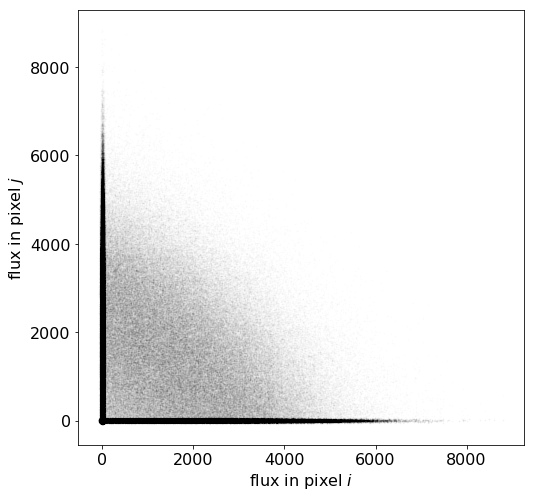

In [34]:
for i in np.arange(sampling.nx - 4) + 2:
    for j in np.arange(sampling.nx - 4) + 2:
        xran = np.random.normal(size=SarrFlat.shape[0]) * 20.
        yran = np.random.normal(size=SarrFlat.shape[0]) * 20.
        plt.scatter(SarrFlat[:, i, j] + xran, SarrFlat[:, i, j + 1] + yran, s=1, alpha=0.007, color='black')
        plt.scatter(SarrFlat[:, i, j] + xran, SarrFlat[:, i, j - 1] + yran, s=1, alpha=0.007, color='black')
        plt.scatter(SarrFlat[:, i, j] + xran, SarrFlat[:, i + 1, j] + yran, s=1, alpha=0.007, color='black')
        plt.scatter(SarrFlat[:, i, j] + xran, SarrFlat[:, i - 1, j] + yran, s=1, alpha=0.007, color='black')
plt.xlabel('flux in pixel $i$')
plt.ylabel('flux in pixel $j$')
plt.savefig('../tex/figures/scattered-nnls-flat-dist-joint.png', dpi=dpi)

In [35]:
SarrVals = SarrFlat[:, 2:-2, 2:-2].flatten()

In [36]:
vals, edges = np.histogram(SarrVals, bins=100, range=[-1., 7500.])
hx = np.zeros(2 * (len(vals) - 2) + 2)
hv = np.zeros(2 * (len(vals) - 2) + 2)
hx[0] = edges[0] 
hv[0] = vals[0] 
for i in np.arange(len(vals) - 2):
    hx[2 * i + 1] = edges[i + 1]
    hv[2 * i + 1] = vals[i]
    hx[2 * i + 2] = edges[i + 1]
    hv[2 * i + 2] = vals[i + 1]
hx[-1] = edges[-1]
hv[-1] = vals[-1]
dx = edges[1] - edges[0]
hv = hv / dx

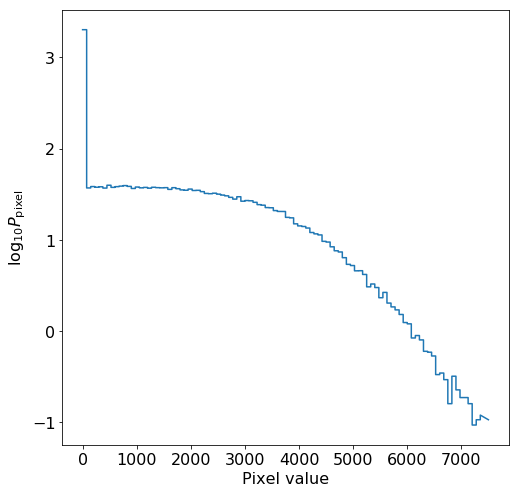

In [37]:
plt.plot(hx, np.log10(hv))
plt.xlabel('Pixel value')
plt.ylabel('$\log_{10} P_{\mathrm{pixel}}$')
plt.savefig('../tex/figures/scattered-nnls-flat-dist.png', dpi=dpi)